# UMAP-based visualization and classification

Aim:  
Use UMAP visualize how tha tabular data gets embedded. In the best case scenario we can dream of a circle corresponding to the cell circle, but we woudl probably get some clusters, more or less close to each other, corresponding to cell cycle, or bad case scenario, to cell type.  
If we have some good embedding, we could use some classifier on this embedded data.

In [5]:
import warnings
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px

import umap
from sklearn.preprocessing import StandardScaler
# import composition_stats as cs # if CLR transfo needed

In [2]:
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
df.set_index(df['CellId'].astype(int), inplace=True)
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 77


In [3]:
df.columns

Index(['3d_image', 'angle', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z',
       'bbox_min_x', 'bbox_min_y', 'bbox_min_z', 'bf_clip_hi', 'bf_clip_lo',
       'cell_height', 'cell_stage', 'cell_surface_area', 'cell_volume',
       'CellId', 'Cellular Component', 'center_slice',
       'Description (from Uniprot)', 'dna_clip_hi', 'dna_clip_lo', 'edge_flag',
       'fits_x', 'fits_y', 'fits_z', 'FOVId', 'gene', 'InstrumentId',
       'max_projection_x', 'max_projection_y', 'max_projection_z',
       'mean_projection_x', 'mean_projection_y', 'mean_projection_z',
       'median_projection_x', 'median_projection_y', 'median_projection_z',
       'membrane_clip_hi', 'membrane_clip_lo', 'meta_colony_area',
       'meta_colony_centroid', 'meta_colony_label', 'meta_fov_edgedist',
       'meta_fov_outside_overview', 'meta_fov_position', 'meta_fov_xcoord',
       'meta_fov_ycoord', 'meta_imaging_mode', 'meta_plate_bad_segmentation',
       'meta_plate_confluency', 'meta_well_passage_at_imaging',
     

In [92]:
emmbed_cols = [
    'cell_height', 'cell_surface_area', 'cell_volume', #'cell_stage',
    'nuclear_height', 'nuclear_surface_area', 'nuclear_volume',
    # 'shape_mode_1_height', 'shape_mode_2_volume',
    # 'shape_mode_3_major_tilt', 'shape_mode_4_minor_tilt',
    # 'shape_mode_5_elongation', 'shape_mode_6_bean-ness',
    # 'shape_mode_7_pear-ness', 'shape_mode_8_wedge',
]
print(f"There are {len(emmbed_cols)} columns")

There are 6 columns


In [93]:
df[emmbed_cols].shape

(214037, 6)

In [94]:
df_fillna = df[emmbed_cols].fillna(0)
df_fillna.shape

(214037, 6)

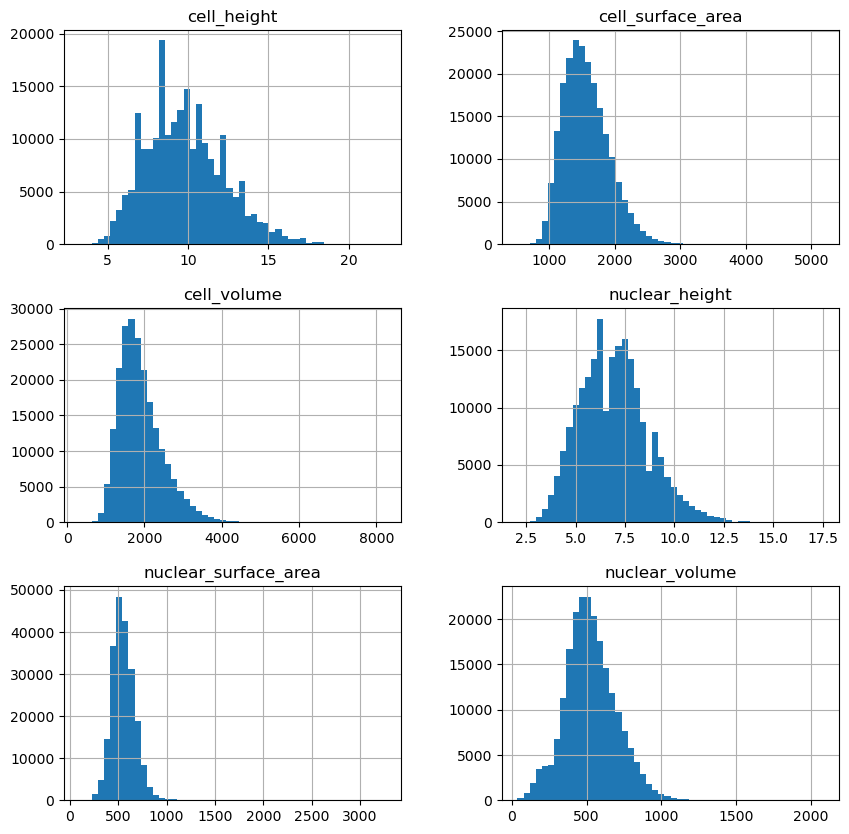

In [95]:
df_fillna.hist(bins=50, figsize=(10, 10));

Variables' distributions look close to normal, except for shape coefficients, but there are lots of 0, so we can probably simply rescale them.

In [96]:
df_std = df_fillna.copy()
std_transformer = StandardScaler()
df_std.loc[:, :] = std_transformer.fit_transform(df_std.loc[:, :])

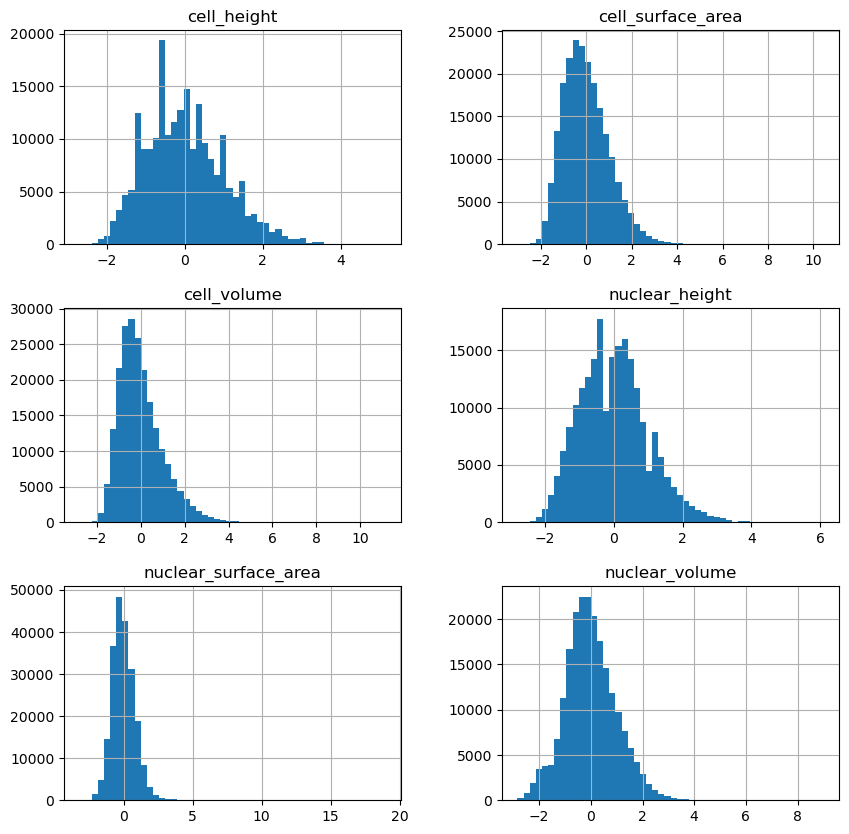

In [97]:
df_std.hist(bins=50, figsize=(10, 10));

In [98]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(df_std)
embedding.shape

(214037, 2)

In [99]:
# For the visualization
marker = '.'
size_points = 10

In [101]:
y = df.loc[df_std.index, 'cell_stage']
import matplotlib.cm as cm

def make_colors(y, cmap_name='tab10'):
    # make a cohort-wide cmap
    cmap = cm.get_cmap(cmap_name).colors
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(y).value_counts().index
    n_colors = len(cmap)
    labels_color_mapper = {x: cmap[i % n_colors] for i, x in enumerate(uniq)}
    # make list of colors
    labels_colors = [labels_color_mapper[x] for x in y]
    labels_colors = pd.Series(labels_colors)
    return labels_colors


In [102]:
y.value_counts()

M0               202847
M6M7_single        3710
M4M5               3099
M1M2               2202
M6M7_complete      1198
M3                  981
Name: cell_stage, dtype: int64

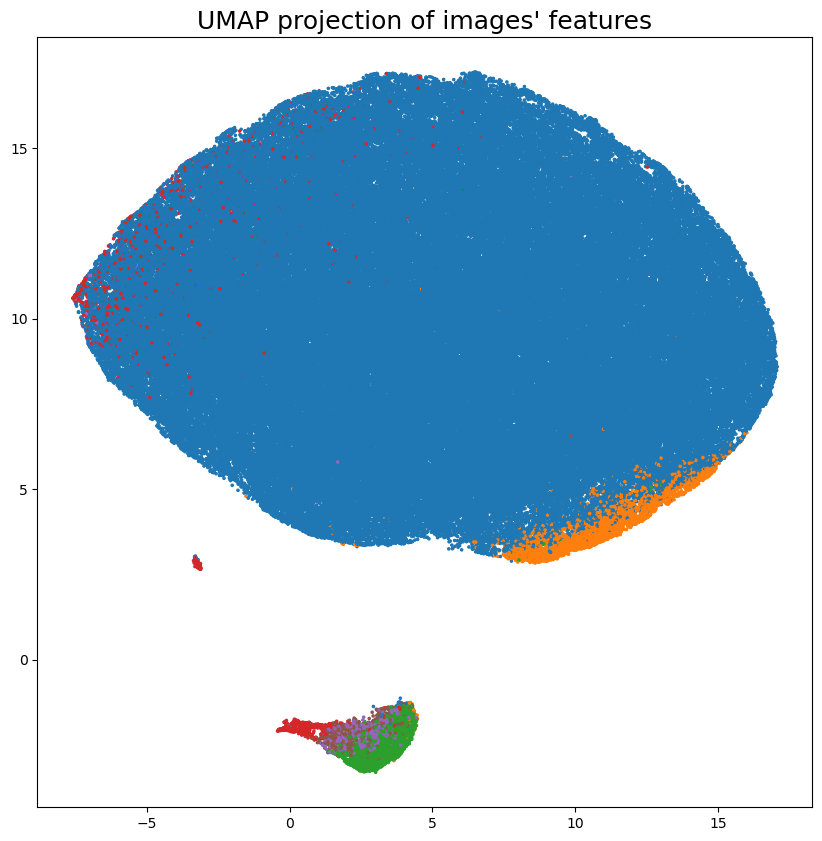

In [103]:
colors = make_colors(y, cmap_name='tab10')

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, marker=marker, s=size_points)
title = "UMAP projection of images' features"
plt.title(title, fontsize=18);

### On the subset

In [104]:
df = pd.read_csv("../data/mitocells.csv")
df.set_index(df['CellId'].astype(int), inplace=True)
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 10381
Number of columns: 79


In [105]:
emmbed_cols = [
    'cell_height', 'cell_surface_area', 'cell_volume', #'cell_stage',
    'nuclear_height', 'nuclear_surface_area', 'nuclear_volume',
    # 'shape_mode_1_height', 'shape_mode_2_volume',
    # 'shape_mode_3_major_tilt', 'shape_mode_4_minor_tilt',
    # 'shape_mode_5_elongation', 'shape_mode_6_bean-ness',
    # 'shape_mode_7_pear-ness', 'shape_mode_8_wedge',
]
print(f"There are {len(emmbed_cols)} columns")

There are 6 columns


In [106]:
df[emmbed_cols].shape

(10381, 6)

In [107]:
df_fillna = df[emmbed_cols].fillna(0)
df_fillna.shape

(10381, 6)

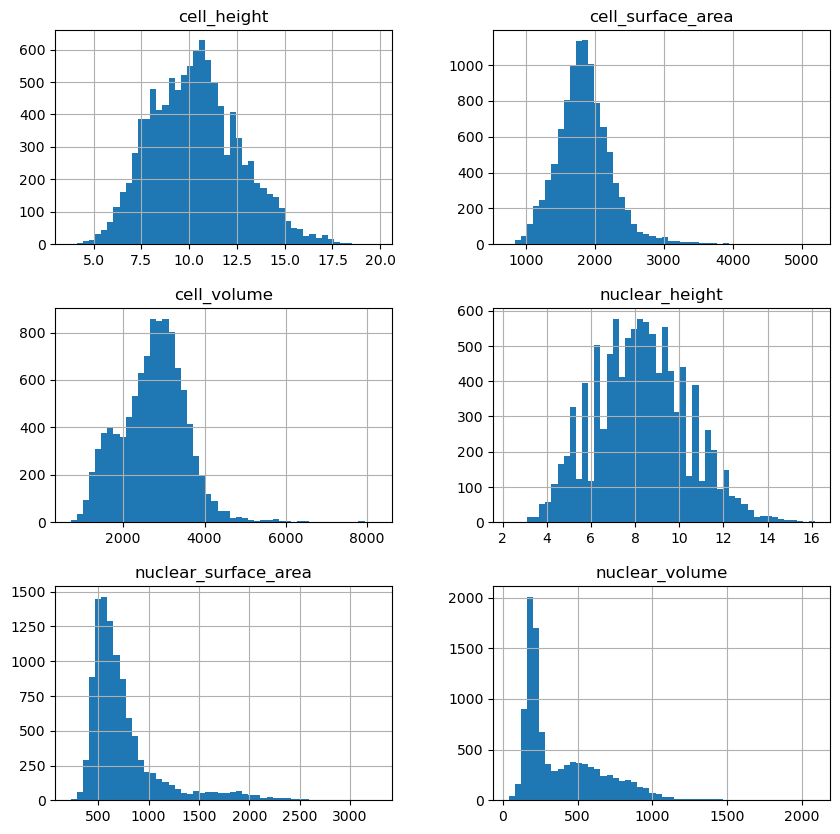

In [108]:
df_fillna.hist(bins=50, figsize=(10, 10));

Variables' distributions look close to normal, except for shape coefficients, but there are lots of 0, so we can probably simply rescale them.

In [109]:
df_std = df_fillna.copy()
std_transformer = StandardScaler()
df_std.loc[:, :] = std_transformer.fit_transform(df_std.loc[:, :])

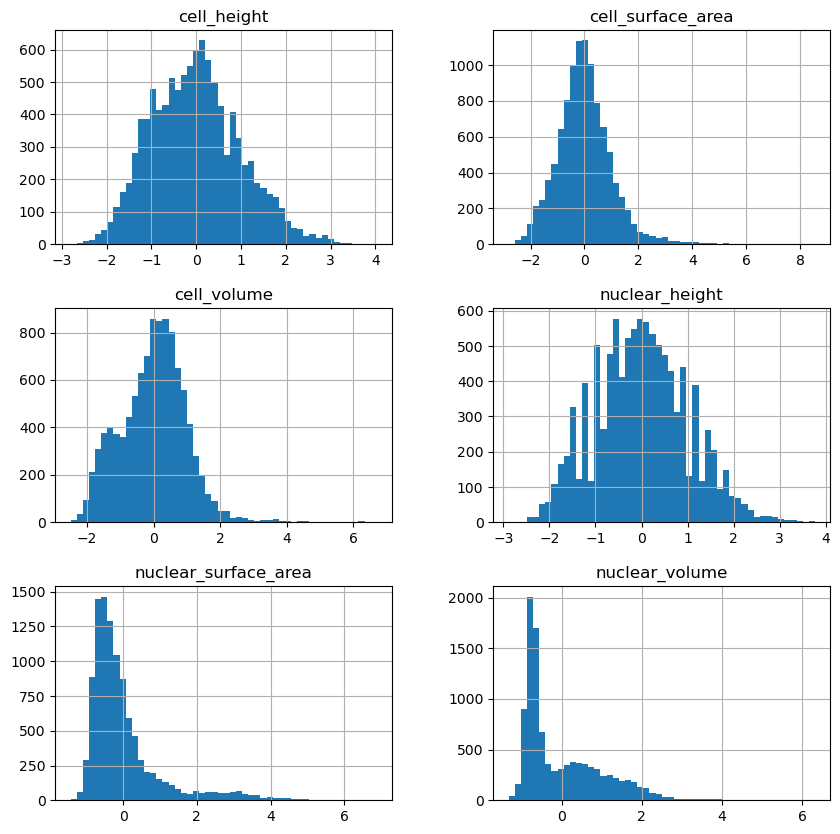

In [110]:
df_std.hist(bins=50, figsize=(10, 10));

In [111]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(df_std)
embedding.shape

(10381, 2)

In [112]:
# For the visualization
marker = '.'
size_points = 10

In [125]:
y = df.loc[df_std.index, 'cell_stage']
import matplotlib.cm as cm

def make_colors(y, cmap_name='tab10', as_series=True):
    # make a cohort-wide cmap
    cmap = cm.get_cmap(cmap_name).colors
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(y).value_counts().index
    n_colors = len(cmap)
    labels_color_mapper = {x: cmap[i % n_colors] for i, x in enumerate(uniq)}
    # make list of colors
    labels_colors = [labels_color_mapper[x] for x in y]
    if as_series:
        labels_colors = pd.Series(labels_colors)
    return labels_colors


In [126]:
y.value_counts()

M0               3000
M4M5             3000
M1M2             2202
M6M7_complete    1198
M3                981
Name: cell_stage, dtype: int64

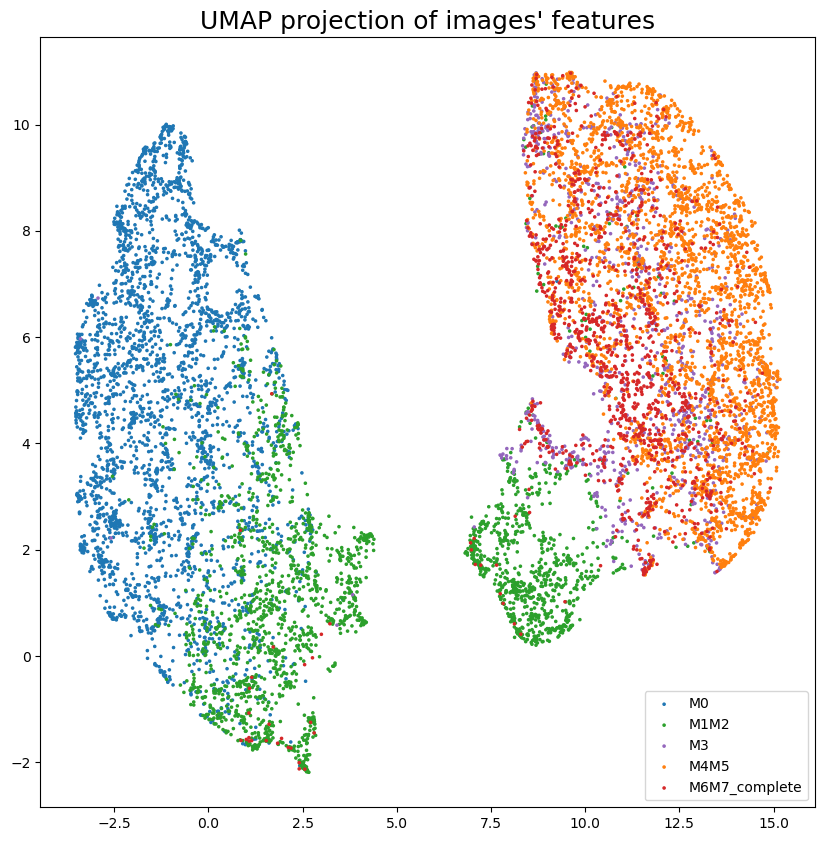

In [129]:
colors = make_colors(y, cmap_name='tab10')
fig, ax = plt.subplots(figsize=[10,10])
for y_class in np.unique(y):
    select = y.values == y_class
    ax.scatter(embedding[select, 0], embedding[select, 1], c=colors[select], marker=marker, s=size_points, label=y_class)
plt.legend()
title = "UMAP projection of images' features"
plt.title(title, fontsize=18);